In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten,  Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import load_img
#from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import cv2
import sys
import bcolz
import random


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


labels.csv
sample_submission.csv
test
train



In [3]:
from glob import *

In [4]:
train_files = glob('../input/train/*.jpg')
test_files = glob('../input/test/*.jpg')

In [5]:
df_train = pd.read_csv('../input/labels.csv')
df_test = pd.read_csv('../input/sample_submission.csv')

In [6]:
len(test_files)

10357

In [7]:
train_files[10]

'../input/train/2f812a0cb6977bbad1a167e1ef4ae2ac.jpg'

In [8]:
import matplotlib.pyplot as plt

In [9]:
from keras.preprocessing import image

In [10]:
im_size=300

In [16]:
y_train = []
y_val = []
x_train_raw = bcolz.zeros((0,im_size,im_size,3),np.float32)
x_val_raw = bcolz.zeros((0,im_size,im_size,3),np.float32)


In [17]:
targets_series = pd.Series(df_train['breed'])
one_hot = pd.get_dummies(targets_series, sparse = True)
one_hot_labels = np.asarray(one_hot)

In [18]:
i = 0 
for f, breed in tqdm(df_train.values):
    # load an image from file
    image = load_img('../input/train/{}.jpg'.format(f), target_size=(im_size, im_size))
    image = img_to_array(image)
    # prepare the image for the VGG model
    #image = preprocess_input(image)
    label = one_hot_labels[i]
    if random.randint(1,101) < 80: 
        x_train_raw.append(image)
        y_train.append(label)
    else:
        x_val_raw.append(image)
        y_val.append(label)
    i += 1

100%|██████████| 10222/10222 [01:09<00:00, 147.00it/s]


In [20]:
y_train_raw = np.array(y_train, np.uint8)
y_val_raw = np.array(y_val, np.uint8)
del(y_train,y_val)
import gc
gc.collect()

655

In [21]:
batch_size = 2
im_size = 300
resize_factor = 0.8

None


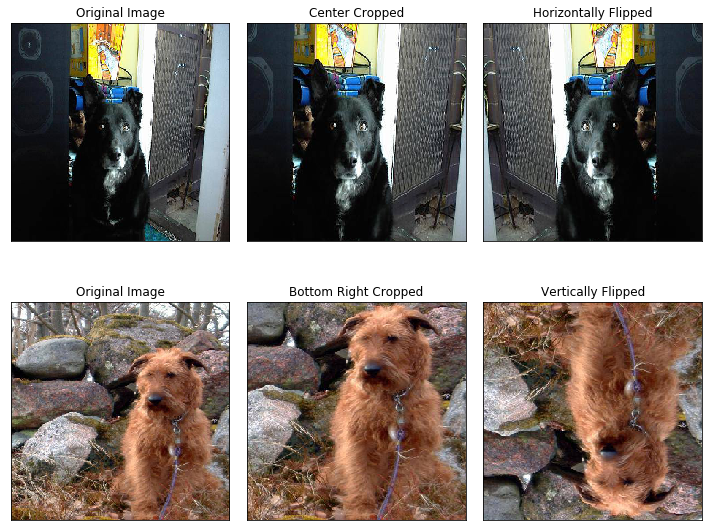

In [22]:
def crop_augment(x_train_raw, batch_size, im_size, resize_factor):
    
    np.random.shuffle(x_train_raw)
    sample=np.random.choice(im_size, batch_size, replace=False)
    
    my_image = []
    image_state = []
    
    for i in (sample):
        res= x_train_raw[i]/255.        
        tag = 'Original Image'
        my_image.append(res)
        image_state.append(tag)

        height,width = res.shape[0], res.shape[1]
        croplen = int(im_size * resize_factor)
        height_start = (height - croplen) // 2
        width_start = (width - croplen) // 2


        x = random.randint(1,101)
        if 0 < x <= 20:
            cropped_image = res[height_start:-height_start,width_start:-width_start,:] 
            tag1 = 'Center Cropped'

        elif 20 < x <= 40:
            
            cropped_image = res[:croplen,width - croplen:,:] 
            tag1 = 'Top Right Cropped'
            
        elif 40 < x <= 60:
    
            cropped_image = res[:croplen,:croplen,:]
            tag1 = 'Top Left Cropped'

        elif 60 < x <= 80:
            
            cropped_image = res[height - croplen:,width - croplen:,:] 
            tag1 = 'Bottom Right Cropped'     

        elif 80 < x <= 100:

            cropped_image = res[height - croplen:,:croplen,:] 
            tag1 = 'Bottom Left Cropped'
            
        my_image.append(cropped_image)      
        image_state.append(tag1)
        
        if x <= 50:
            flipped_image = cropped_image[:,::-1]
            tag2 = 'Horizontally Flipped'
    
        elif x > 50:
            flipped_image = cropped_image[::-1,:]
            tag2 = 'Vertically Flipped'
            
            
        my_image.append(flipped_image)
        image_state.append(tag2)

    images = my_image
    labels = image_state
    fig, axes = plt.subplots(2,3,figsize=(10,10))
    axes = axes.flatten()
    i = 0
    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.set_xticks(())
        ax.set_yticks(())
        if i==0:
            ax.set_title(labels[0])
        if i==1:
            ax.set_title(labels[1])
        if i==2:
            ax.set_title(labels[2])
        if i==3:
            ax.set_title(labels[3])
        if i==4:
            ax.set_title(labels[4])
        if i==5:
            ax.set_title(labels[5])
        i+=1
        plt.tight_layout()

a = crop_augment(x_train_raw, batch_size, im_size, resize_factor)
print(a)
